# Additional Models

This notebook compares the SLSQP ensemble's performance across differnt configurations of base models, ranging from three to six base models across the following base models: Chronos-2, FlowState, Moirai 2.0, Sundial 128M, TimesFM 2.5, and Toto 1.0.

Import packages.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import re

from itertools import combinations
from src.utils.path import resolve_results_path
from tqdm import tqdm

Find all of the  SLSQP ensemble model-configurations' results directories.

In [60]:
ensemble = "SLSQPEnsemble"
metric = "mae"
num_windows = 1

results_path = resolve_results_path()

# Find all SLSQP ensemble model-configuration results directories
pattern = rf".*{ensemble}.*opt-{metric}.*{num_windows}-windows.*"
matching_dirs = [
    dir
    for dir in results_path.iterdir()
    if dir.is_dir() and re.search(pattern, dir.name)
]

print(f"Found {len(matching_dirs)} {ensemble} model-configurations' results:")
for i, dir in enumerate(matching_dirs):
    print(f"{i + 1}. {dir.name}")

Found 9 SLSQPEnsemble model-configurations' results:
1. SLSQPEnsemble_3-models_chronos-flowstate-timesfm_opt-mae_1-windows
2. SLSQPEnsemble_3-models_moirai-sundial-toto_opt-mae_1-windows
3. SLSQPEnsemble_4-models_chronos-moirai-sundial-toto_opt-mae_1-windows
4. SLSQPEnsemble_4-models_flowstate-moirai-sundial-toto_opt-mae_1-windows
5. SLSQPEnsemble_4-models_moirai-sundial-timesfm-toto_opt-mae_1-windows
6. SLSQPEnsemble_5-models_chronos-flowstate-moirai-sundial-toto_opt-mae_1-windows
7. SLSQPEnsemble_5-models_chronos-moirai-sundial-timesfm-toto_opt-mae_1-windows
8. SLSQPEnsemble_5-models_flowstate-moirai-sundial-timesfm-toto_opt-mae_1-windows
9. SLSQPEnsemble_6-models_chronos-flowstate-moirai-sundial-timesfm-toto_opt-mae_1-windows


Aggregate each model-configuration's results into a single CSV file.

In [61]:
all_results_dir = "all_results"
file_name = "all_results.csv"

kwargs = {
    "desc": "Aggregating results",
    "total": len(matching_dirs),
    "unit": "model config",
}

for dir in tqdm(matching_dirs, **kwargs):
    csv_files = dir.rglob("*.csv")
    df = pd.concat([pd.read_csv(f).tail(1) for f in csv_files])

    # Ensure the model column contains the base model names
    df["model"] = dir.name

    out_path = resolve_results_path() / all_results_dir / dir.name / file_name
    out_path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(out_path, index=False)

Aggregating results: 100%|██████████| 9/9 [00:01<00:00,  4.90model config/s]


Load each model configuration's aggregated results into a single dataframe.

In [62]:
keys, merged_df = ["dataset", "domain", "num_variates"], None

kwargs = {
    "desc": "Combining results across configs",
    "total": len(matching_dirs),
    "unit": "model config",
}

for i, dir in tqdm(enumerate(matching_dirs), **kwargs):
    input_path = resolve_results_path() / all_results_dir / dir.name / file_name
    df = pd.read_csv(input_path)

    # Rename each dataframe's columns before merging
    df = df.rename(columns=lambda c: f"{c}_{i}" if c not in keys else c)
    merged_df = (
        df
        if merged_df is None
        else pd.merge(
            merged_df,
            df,
            on=keys,
            how="inner",
        )
    )

print(f"Number of rows: {len(merged_df)}")
merged_df.head()

Combining results across configs: 100%|██████████| 9/9 [00:00<00:00, 112.11model config/s]

Number of rows: 5


,dataset,model_0,eval_metrics/MSE[mean]_0,eval_metrics/MSE[0.5]_0,eval_metrics/MAE[0.5]_0,eval_metrics/MASE[0.5]_0,eval_metrics/MAPE[0.5]_0,eval_metrics/sMAPE[0.5]_0,eval_metrics/MSIS_0,eval_metrics/RMSE[mean]_0,...,eval_metrics/MSE[0.5]_8,eval_metrics/MAE[0.5]_8,eval_metrics/MASE[0.5]_8,eval_metrics/MAPE[0.5]_8,eval_metrics/sMAPE[0.5]_8,eval_metrics/MSIS_8,eval_metrics/RMSE[mean]_8,eval_metrics/NRMSE[mean]_8,eval_metrics/ND[0.5]_8,eval_metrics/mean_weighted_sum_quantile_loss_8
0,covid_deaths/D/short,SLSQPEnsemble_3-models_chronos-flowstate-times...,5.813768e+05,5.813768e+05,128.705369,35.938893,0.095008,0.374015,708.460797,762.480666,...,3.119924e+05,98.592794,36.690201,0.095031,0.375258,757.462743,558.562764,0.210162,0.037096,0.030970
1,hospital/M/short,SLSQPEnsemble_3-models_chronos-flowstate-times...,2.846692e+03,2.846692e+03,17.822003,0.753891,0.190391,0.171945,5.016206,53.354400,...,2.697982e+03,17.663484,0.753968,0.189488,0.171566,5.029377,51.942103,0.188562,0.064123,0.050246
2,us_births/D/short,SLSQPEnsemble_3-models_chronos-flowstate-times...,1.361437e+05,1.361437e+05,221.820000,0.326542,0.021230,0.021208,2.635652,368.976612,...,1.361856e+05,221.820000,0.326541,0.021233,0.021202,2.570550,369.033268,0.034594,0.020794,0.016523
3,us_births/M/short,SLSQPEnsemble_3-models_chronos-flowstate-times...,3.972660e+07,3.972660e+07,5216.296998,0.588763,0.016061,0.016235,4.171646,6302.904331,...,3.551525e+07,4789.196406,0.540666,0.014786,0.014937,4.081046,5959.467371,0.018510,0.014875,0.011517
4,us_births/W/short,SLSQPEnsemble_3-models_chronos-flowstate-times...,1.930535e+06,1.930535e+06,1081.783271,0.983535,0.014695,0.014715,5.570850,1389.436852,...,1.613245e+06,981.718700,0.892999,0.013338,0.013365,5.278030,1270.136016,0.017242,0.013327,0.010384


Remove unnecessary metrics and rename the MASE and CRPS columns.

In [63]:
pattern = re.compile(r"(model|MASE|mean_weighted_sum_quantile_loss)")
keep_cols = keys + [col for col in merged_df.columns if pattern.search(col)]
merged_df = merged_df[keep_cols]

merged_df = merged_df.rename(
    columns=lambda c: re.sub(r"eval_metrics/MASE\[.*?\]_(\d+)", r"MASE_\1", c)
).rename(
    columns=lambda c: re.sub(
        r"eval_metrics/mean_weighted_sum_quantile_loss_(\d+)", r"CRPS_\1", c
    )
)

print(f"Number of rows: {len(merged_df)}")
merged_df.head()

Number of rows: 5


,dataset,domain,num_variates,model_0,MASE_0,CRPS_0,model_1,MASE_1,CRPS_1,model_2,...,CRPS_5,model_6,MASE_6,CRPS_6,model_7,MASE_7,CRPS_7,model_8,MASE_8,CRPS_8
0,covid_deaths/D/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,35.938893,0.039235,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,37.564913,0.029188,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,0.030970,SLSQPEnsemble_5-models_chronos-moirai-sundial-...,36.690201,0.030970,SLSQPEnsemble_5-models_flowstate-moirai-sundia...,37.743647,0.028844,SLSQPEnsemble_6-models_chronos-flowstate-moira...,36.690201,0.030970
1,hospital/M/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,0.753891,0.050373,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.772955,0.053985,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,0.050868,SLSQPEnsemble_5-models_chronos-moirai-sundial-...,0.757646,0.050643,SLSQPEnsemble_5-models_flowstate-moirai-sundia...,0.753630,0.050211,SLSQPEnsemble_6-models_chronos-flowstate-moira...,0.753968,0.050246
2,us_births/D/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,0.326542,0.016536,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.357492,0.018616,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,0.016523,SLSQPEnsemble_5-models_chronos-moirai-sundial-...,0.326541,0.016523,SLSQPEnsemble_5-models_flowstate-moirai-sundia...,0.334204,0.017747,SLSQPEnsemble_6-models_chronos-flowstate-moira...,0.326541,0.016523
3,us_births/M/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,0.588763,0.012270,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.647543,0.013392,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,0.011517,SLSQPEnsemble_5-models_chronos-moirai-sundial-...,0.540666,0.011517,SLSQPEnsemble_5-models_flowstate-moirai-sundia...,0.647543,0.013392,SLSQPEnsemble_6-models_chronos-flowstate-moira...,0.540666,0.011517
4,us_births/W/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,0.983535,0.011468,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.891431,0.010594,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,0.010384,SLSQPEnsemble_5-models_chronos-moirai-sundial-...,0.882640,0.010216,SLSQPEnsemble_5-models_flowstate-moirai-sundia...,0.918730,0.010606,SLSQPEnsemble_6-models_chronos-flowstate-moira...,0.892999,0.010384


For each configuration, add a column containing the number of models and boolean columns indicating which models were used.

In [64]:
def extract_models(model_string: str):
    match = re.search(r"models_(.+?)_opt", model_string)
    return [] if not match else match.group(1).split("-")


model_cols = [col for col in merged_df.columns if col.startswith("model_")]

all_base_models = set()

for col in model_cols:
    models_lists = merged_df[col].apply(extract_models)

    # Store count per config
    merged_df[f"num_models_{col.split('_')[1]}"] = models_lists.apply(len)

    # Track all unique models across all configs
    for lst in models_lists:
        all_base_models.update(lst)

all_base_models = sorted(all_base_models)

for base in all_base_models:
    for col in model_cols:
        idx = col.split("_")[1]
        merged_df[f"{base}_{idx}"] = merged_df[col].apply(
            lambda s: base in extract_models(s)
        )

merged_df.head()

,dataset,domain,num_variates,model_0,MASE_0,CRPS_0,model_1,MASE_1,CRPS_1,model_2,...,timesfm_8,toto_0,toto_1,toto_2,toto_3,toto_4,toto_5,toto_6,toto_7,toto_8
0,covid_deaths/D/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,35.938893,0.039235,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,37.564913,0.029188,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,True,False,True,True,True,True,True,True,True,True
1,hospital/M/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,0.753891,0.050373,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.772955,0.053985,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,True,False,True,True,True,True,True,True,True,True
2,us_births/D/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,0.326542,0.016536,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.357492,0.018616,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,True,False,True,True,True,True,True,True,True,True
3,us_births/M/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,0.588763,0.012270,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.647543,0.013392,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,True,False,True,True,True,True,True,True,True,True
4,us_births/W/short,Healthcare,1,SLSQPEnsemble_3-models_chronos-flowstate-times...,0.983535,0.011468,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,0.891431,0.010594,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,...,True,False,True,True,True,True,True,True,True,True


## Model Choice

Create a dataframe of that contains the number of models used in each config and booleans indicating which models were used.

In [66]:
model_cols = [c for c in merged_df.columns if c.startswith("model_")]
configs = []

for col in model_cols:
    idx = col.split("_")[1]
    row = {
        "config_idx": int(idx),
        "model_name": merged_df[col].iloc[0],
        "mean_MASE": merged_df[f"MASE_{idx}"].mean(),
        "mean_CRPS": merged_df[f"CRPS_{idx}"].mean(),
        "num_models": merged_df[f"num_models_{idx}"].iloc[0],
    }

    # Add inclusion booleans for all models
    for model in all_base_models:
        row[model] = merged_df[f"{model}_{idx}"].iloc[0]

    configs.append(row)

config_df = pd.DataFrame(configs)
print(f"Number of rows: {len(config_df)}")
config_df.head()

Number of rows: 9


,config_idx,model_name,mean_MASE,mean_CRPS,num_models,chronos,flowstate,moirai,sundial,timesfm,toto
0,0,SLSQPEnsemble_3-models_chronos-flowstate-times...,7.718325,0.025976,3,True,True,False,False,True,False
1,1,SLSQPEnsemble_3-models_moirai-sundial-toto_opt...,8.046867,0.025155,3,False,False,True,True,False,True
2,2,SLSQPEnsemble_4-models_chronos-moirai-sundial-...,7.841850,0.024528,4,True,False,True,True,False,True
3,3,SLSQPEnsemble_4-models_flowstate-moirai-sundia...,8.116350,0.024655,4,False,True,True,True,False,True
4,4,SLSQPEnsemble_4-models_moirai-sundial-timesfm-...,8.021343,0.024572,4,False,False,True,True,True,True


Compare performance when including vs excluding combinations of Chronos-2, FlowState, and TimesFM 2.5 added to the original ensemble of Moira 2.0, Sundial, and Toto 1.0.

In [67]:
models_of_interest = ["chronos", "timesfm", "flowstate"]
groups = []

for r in (1, 2):
    groups.extend(combinations(models_of_interest, r))

# Explicitly add the "all models" combo
groups.append(tuple(models_of_interest))

effects = []
for combo in groups:
    included_mask = config_df[list(combo)].all(axis=1)
    excluded_mask = ~included_mask

    included = config_df[included_mask]
    excluded = config_df[excluded_mask]

    effects.append(
        {
            "group": " & ".join(combo),
            "size": len(combo),
            "MASE_if_included": included["mean_MASE"].mean(),
            "MASE_if_excluded": excluded["mean_MASE"].mean(),
            "CRPS_if_included": included["mean_CRPS"].mean(),
            "CRPS_if_excluded": excluded["mean_CRPS"].mean(),
            "delta_MASE": included["mean_MASE"].mean() - excluded["mean_MASE"].mean(),
            "delta_CRPS": included["mean_CRPS"].mean() - excluded["mean_CRPS"].mean(),
        }
    )

effects_df = pd.DataFrame(effects)
effects_df

,group,size,MASE_if_included,MASE_if_excluded,CRPS_if_included,CRPS_if_excluded,delta_MASE,delta_CRPS
0,chronos,1,7.816314,8.066028,0.024492,0.024635,-0.249714,-0.000144
1,timesfm,1,7.899927,7.961511,0.024522,0.024598,-0.061585,-0.000075
2,flowstate,1,7.919216,7.937400,0.024554,0.024557,-0.018184,-0.000003
3,chronos & timesfm,2,7.799580,7.991157,0.024626,0.024520,-0.191577,0.000106
4,chronos & flowstate,2,7.800060,7.990917,0.024652,0.024507,-0.190857,0.000145
5,timesfm & flowstate,2,7.879584,7.951155,0.024688,0.024489,-0.071571,0.000199
6,chronos & timesfm & flowstate,3,7.779600,7.969497,0.024952,0.024442,-0.189897,0.000510


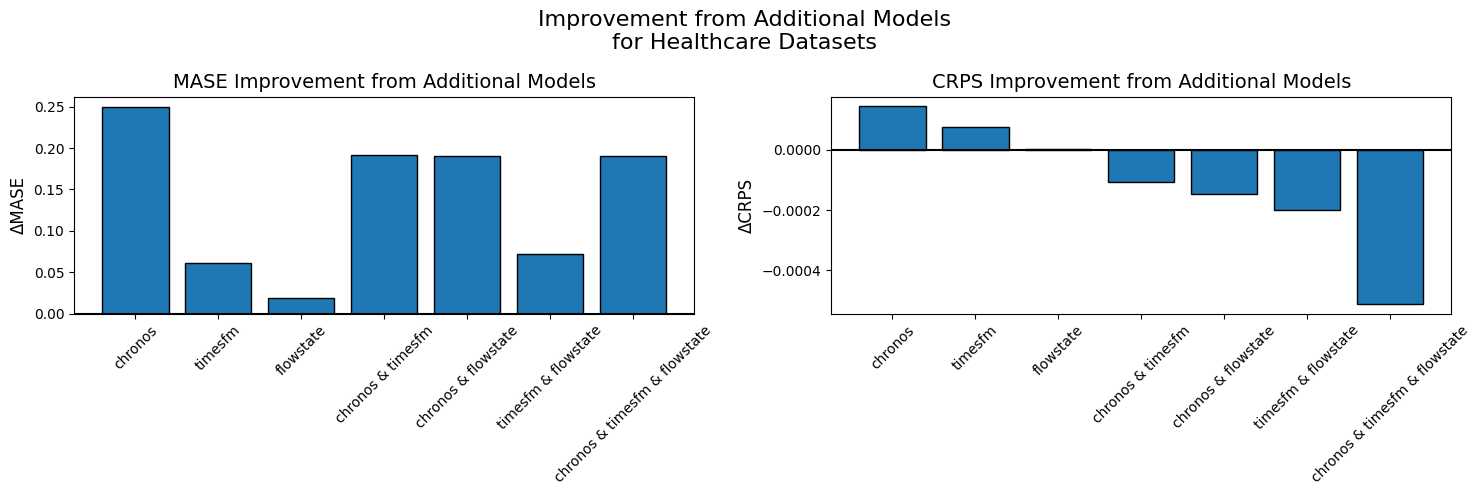

In [68]:
# Convert deltas so positive means improvement
effects_df["improvement_MASE"] = -effects_df["delta_MASE"]
effects_df["improvement_CRPS"] = -effects_df["delta_CRPS"]

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)

metrics = ["MASE", "CRPS"]

for i, metric in enumerate(metrics):
    axes[i].bar(
        effects_df["group"],
        effects_df[f"improvement_{metric}"],
        edgecolor="black",
    )
    axes[i].axhline(0, color="black")
    axes[i].set_ylabel(
        f"Δ{metric}",
        fontsize=12,
    )
    axes[i].set_title(
        f"{metric} Improvement from Additional Models",
        fontsize=14,
    )
    axes[i].tick_params(axis="x", rotation=45)

plt.suptitle(
    "Improvement from Additional Models\nfor Healthcare Datasets",
    fontsize=16,
)
plt.tight_layout()
plt.show()